# Prot T5 Finetuning
# per residue regression

This notebook allows you to finetune PLMs to your own datasets

For better perfomance we apply [Parameter-Efficient Fine-Tuning (PEFT)](https://huggingface.co/blog/peft). For this we apply [LoRA: Low-Rank Adaptation of Large Language Models](https://arxiv.org/abs/2106.09685).

The core training loop is implemented with the pytorch [huggingface trainer](https://huggingface.co/docs/transformers/main_classes/trainer).

In case it is needed for higher memory efficiency, we utilize the [deepspeed](https://github.com/microsoft/DeepSpeed) implementation of [huggingface](https://huggingface.co/docs/accelerate/usage_guides/deepspeed).

## Imports and env. variables

In [1]:
#import dependencies
import os.path
os.chdir("set working path here")

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss
from torch.utils.data import DataLoader

import re
import numpy as np
import pandas as pd
import copy

import transformers, datasets
from transformers.modeling_outputs import TokenClassifierOutput
from transformers.models.t5.modeling_t5 import T5Config, T5PreTrainedModel, T5Stack
from transformers.utils.model_parallel_utils import assert_device_map, get_device_map
from transformers import T5EncoderModel, T5Tokenizer
from transformers.models.esm.modeling_esm import EsmPreTrainedModel, EsmModel
from transformers import AutoTokenizer
from transformers import TrainingArguments, Trainer, set_seed
from transformers import DataCollatorForTokenClassification

from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple, Union

# for custom DataCollator
from transformers.data.data_collator import DataCollatorMixin
from transformers.tokenization_utils_base import PreTrainedTokenizerBase
from transformers.utils import PaddingStrategy

import peft
from peft import get_peft_config, PeftModel, PeftConfig, inject_adapter_in_model, LoraConfig

from evaluate import load
from datasets import Dataset

from tqdm import tqdm
import random

from scipy import stats
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

In [2]:
# Set environment variables to run Deepspeed from a notebook
os.environ["MASTER_ADDR"] = "localhost"
os.environ["MASTER_PORT"] = "9992"  # modify if RuntimeError: Address already in use
os.environ["RANK"] = "0"
os.environ["LOCAL_RANK"] = "0"
os.environ["WORLD_SIZE"] = "1"

# Environment to run this notebook


These are the versions of the core packages we use to run this notebook:

In [3]:
print("Torch version: ",torch.__version__)
print("Cuda version: ",torch.version.cuda)
print("Numpy version: ",np.__version__)
print("Pandas version: ",pd.__version__)
print("Transformers version: ",transformers.__version__)
print("Datasets version: ",datasets.__version__)

Torch version:  1.13.1
Cuda version:  11.7
Numpy version:  1.22.3
Pandas version:  2.0.3
Transformers version:  4.26.1
Datasets version:  2.9.0


**For easy setup of this environment you can use the finetuning.yml File provided in this folder**

check here for [setting up env from a yml File](https://conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html#creating-an-environment-from-an-environment-yml-file)

# Valid Model checkpoints

This notebook was tested with all models mentioned below.
All required, model specific adaptations will be taken care of.

In [4]:
ESMs = ["facebook/esm2_t6_8M_UR50D",
         "facebook/esm2_t12_35M_UR50D",
         "facebook/esm2_t30_150M_UR50D",
         "facebook/esm2_t33_650M_UR50D",
         "facebook/esm2_t36_3B_UR50D"]

T5s = ["Rostlab/prot_t5_xl_uniref50",
       'Rostlab/ProstT5',
       "ElnaggarLab/ankh-base",
       "ElnaggarLab/ankh-large"]

### Select your model:

In [5]:
checkpoint = T5s[0]

# Input data

Provide your training and validation data in seperate pandas dataframes 

example shown below

**Modify the data loading part as needed for your data**

To run the training you need two dataframes (training and validation) each with the columns "sequence" and "label"

Columns are:
+ protein sequence
+ label is a list of len(protein sequence) with float numbers corresponding to predicted regression value at this position.
  If you want to ignore certain positions during training, put a -100 in label at the corresponding positions

In [6]:
# For this example we import the disorder dataset from https://github.com/DagmarIlz/SETH/
# For details, see publication here: https://www.frontiersin.org/articles/10.3389/fbinf.2022.1019597/full

from Bio import SeqIO
from io import StringIO
import requests
import tempfile

from sklearn.model_selection import train_test_split
import csv

In [7]:
# Load training sequences
url = "https://raw.githubusercontent.com/DagmarIlz/SETH/main/datasets/CheZOD1174_training_set_sequences.fasta"

response = requests.get(url)
response.raise_for_status()  # Check if the request was successful

# Create a StringIO object to simulate a file-like object
fasta_file = StringIO(response.text)

# Load FASTA file using Biopython
sequences = []
for record in SeqIO.parse(fasta_file, "fasta"):
    sequences.append([record.name, str(record.seq)])

# Create dataframe
df = pd.DataFrame(sequences, columns=["name", "sequence"])
df.head(5)

,name,sequence
0,26672,MASNDYTQQATQSYGAYPTQPGQGYSQQSSQPYGQQSYSGYSQSTD...
1,26654,GTRGDADMYDLPKKEDALLYQSKGYNDDYYEESYFTTRTYGEPESA...
2,25586,SLTLNLITEMGRLPTFMTQKARDALDNLAVLHTAEAGGRAYNHALSEL
3,25399,RLDKQGNFNAWVAGSYGNDQWLQVDLGSSKEVTGIITQGARNFGSV...
4,25185,MGTSAPNNTNNANSSITPAFGSNNTGNTAFGNSNPTSNVFGSNNST...


In [8]:
# Load training labels (CheZOD_scores)
url = "https://raw.githubusercontent.com/DagmarIlz/SETH/main/datasets/CheZOD1174_training_set_CheZOD_scores.txt"

response = requests.get(url)
response.raise_for_status()  # Check if the request was successful

lines = response.text.splitlines()

names=[]
labels=[]

# Split each line into name and label
for l in lines:
    names.append(l.split(":\t")[0])
    labels.append(l.split(":\t")[1].split(", "))

# Covert labels to float values
for l in range(0,len(labels)):
    labels[l]=[float(label) for label in labels[l]]
    
# check if sequence names match
print(list(df.name) == names)

True


In [9]:
# Create train and validation dataframes

# Add label column
df["label"] = labels
# drop name column
df = df [["sequence", "label"]]

# Split of 10% of training data as validation split
train, valid = train_test_split(df, test_size=0.1, random_state=42)
train.reset_index(drop=True,inplace=True)
valid.reset_index(drop=True,inplace=True)

# Replace invalid labels (>900) with -100 (will be ignored by pytorch loss)
train['label'] = train.apply(lambda row:  [-100 if x > 900 else x for x in row['label']], axis=1)
valid['label'] = valid.apply(lambda row:  [-100 if x > 900 else x for x in row['label']], axis=1)

In [10]:
train.head(5)

,sequence,label
0,GVGETKVIYHLDEEETPYLVKIPVPAERITLGDFKSVLQRPAGAKY...,"[-100, 3.219, 4.014, 3.745, 3.53, 2.301, 3.204..."
1,GSSGSSGRKKPVSQSLEFPTRYSPYRPYRCVHQGCFAAFTIQQNLI...,"[-100, -100, -100, -100, -100, -100, -2.194, -..."
2,GIHKQKEKSRLQGGVLVNEILNHMKRATQIPSYKKLIMY,"[-100, 6.476, 6.296, 7.407, 5.346, 5.509, 4.99..."
3,MGMIVFVRFNSSYGFPVEVDSDTSILQLKEVVAKRQGVPADQLRVI...,"[-100, 9.189, 10.389, 12.882, 12.002, 14.043, ..."
4,SVLQVLHIPDERLRKVAKPVEEVNAEIQRIVDDMFETMYAEEGIGL...,"[-100, 9.978, 12.505, 13.381, 13.069, 13.551, ..."


In [11]:
valid.head(5)

,sequence,label
0,ETGDIVETATGAGSFTTLLTAAEAAGLVDTLKGDGPFTVFAPTDAA...,"[-100, 8.323, 10.063, 11.146, 12.718, 13.846, ..."
1,GSSGSSGEGLDYLTAPNPPSIREELCTASHDTITVHWISDDEFSIS...,"[-100, -100, -100, -100, -0.834, -1.46, -0.909..."
2,GAMGMSVADFYGSNVEVLLNNDSKARGVITNFDSSNSILQLRLAND...,"[-100, -100, -100, -100, 5.854, 9.065, 12.211,..."
3,MGSSHHHHHHSSHMLVPRGSSKNPLLGKKRALLLSEPSLLRTVQQI...,"[-100, -100, -100, -100, -100, -100, -100, -10..."
4,GSSLQNNQDVSFENIQWSIDPGADLSQYKMDVTVIDTKDGSQSKLG...,"[-100, -100, 3.71, 4.443, 6.613, 5.956, 5.117,..."


# Models and Low Rank Adaptation

## T5 Models

### Regression model definition 

adding a token regression head on top of the encoder model

modified from [EsmForTokenClassification](https://github.com/huggingface/transformers/blob/v4.30.0/src/transformers/models/esm/modeling_esm.py#L1178)

In [12]:
class ClassConfig:
    def __init__(self, dropout=0.2, num_labels=1):
        self.dropout_rate = dropout
        self.num_labels = num_labels

class T5EncoderForTokenRegression(T5PreTrainedModel):

    def __init__(self, config: T5Config, class_config):
        super().__init__(config)
        self.num_labels = class_config.num_labels
        self.config = config

        self.shared = nn.Embedding(config.vocab_size, config.d_model)

        encoder_config = copy.deepcopy(config)
        encoder_config.use_cache = False
        encoder_config.is_encoder_decoder = False
        self.encoder = T5Stack(encoder_config, self.shared)

        self.dropout = nn.Dropout(class_config.dropout_rate) 
        self.classifier = nn.Linear(config.hidden_size, class_config.num_labels)

        # Initialize weights and apply final processing
        self.post_init()

        # Model parallel
        self.model_parallel = False
        self.device_map = None

    def parallelize(self, device_map=None):
        self.device_map = (
            get_device_map(len(self.encoder.block), range(torch.cuda.device_count()))
            if device_map is None
            else device_map
        )
        assert_device_map(self.device_map, len(self.encoder.block))
        self.encoder.parallelize(self.device_map)
        self.classifier = self.classifier.to(self.encoder.first_device)
        self.model_parallel = True

    def deparallelize(self):
        self.encoder.deparallelize()
        self.encoder = self.encoder.to("cpu")
        self.model_parallel = False
        self.device_map = None
        torch.cuda.empty_cache()

    def get_input_embeddings(self):
        return self.shared

    def set_input_embeddings(self, new_embeddings):
        self.shared = new_embeddings
        self.encoder.set_input_embeddings(new_embeddings)

    def get_encoder(self):
        return self.encoder

    def _prune_heads(self, heads_to_prune):
        """
        Prunes heads of the model. heads_to_prune: dict of {layer_num: list of heads to prune in this layer} See base
        class PreTrainedModel
        """
        for layer, heads in heads_to_prune.items():
            self.encoder.layer[layer].attention.prune_heads(heads)

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            inputs_embeds=inputs_embeds,
            head_mask=head_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        sequence_output = outputs[0]
        sequence_output = self.dropout(sequence_output)
        logits = self.classifier(sequence_output)

        loss = None
        if labels is not None:
            loss_fct = MSELoss()

            active_loss = attention_mask.view(-1) == 1
            active_logits = logits.view(-1)

            active_labels = torch.where(
              active_loss, labels.view(-1), torch.tensor(-100).type_as(labels)
            )

            valid_logits=active_logits[active_labels!=-100]
            valid_labels=active_labels[active_labels!=-100]

            loss = loss_fct(valid_logits, valid_labels)
            
        
        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return TokenClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

### T5 Data collator

In [13]:
# based on transformers DataCollatorForTokenClassification
@dataclass
class DataCollatorForTokenRegression_t5(DataCollatorMixin):
    """
    Data collator that will dynamically pad the inputs received, as well as the labels.
    Args:
        tokenizer ([`PreTrainedTokenizer`] or [`PreTrainedTokenizerFast`]):
            The tokenizer used for encoding the data.
        padding (`bool`, `str` or [`~utils.PaddingStrategy`], *optional*, defaults to `True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            - `True` or `'longest'` (default): Pad to the longest sequence in the batch (or no padding if only a single
              sequence is provided).
            - `'max_length'`: Pad to a maximum length specified with the argument `max_length` or to the maximum
              acceptable input length for the model if that argument is not provided.
            - `False` or `'do_not_pad'`: No padding (i.e., can output a batch with sequences of different lengths).
        max_length (`int`, *optional*):
            Maximum length of the returned list and optionally padding length (see above).
        pad_to_multiple_of (`int`, *optional*):
            If set will pad the sequence to a multiple of the provided value.
            This is especially useful to enable the use of Tensor Cores on NVIDIA hardware with compute capability >=
            7.5 (Volta).
        label_pad_token_id (`int`, *optional*, defaults to -100):
            The id to use when padding the labels (-100 will be automatically ignore by PyTorch loss functions).
        return_tensors (`str`):
            The type of Tensor to return. Allowable values are "np", "pt" and "tf".
    """

    tokenizer: PreTrainedTokenizerBase
    padding: Union[bool, str, PaddingStrategy] = True
    max_length: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    label_pad_token_id: int = -100
    return_tensors: str = "pt"

    def torch_call(self, features):
        import torch

        label_name = "label" if "label" in features[0].keys() else "labels"
        labels = [feature[label_name] for feature in features] if label_name in features[0].keys() else None

        no_labels_features = [{k: v for k, v in feature.items() if k != label_name} for feature in features]

        batch = self.tokenizer.pad(
            no_labels_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )

        if labels is None:
            return batch

        sequence_length = batch["input_ids"].shape[1]
        padding_side = self.tokenizer.padding_side

        def to_list(tensor_or_iterable):
            if isinstance(tensor_or_iterable, torch.Tensor):
                return tensor_or_iterable.tolist()
            return list(tensor_or_iterable)

        if padding_side == "right":
            batch[label_name] = [
                to_list(label) + [self.label_pad_token_id] * (sequence_length - len(label)) for label in labels
                ]
        else:
            batch[label_name] = [
                [self.label_pad_token_id] * (sequence_length - len(label)) + to_list(label) for label in labels
                ]
        # change datatype from torch.int64 to torch.float
        batch[label_name] = torch.tensor(batch[label_name], dtype=torch.float)
        return batch

def _torch_collate_batch(examples, tokenizer, pad_to_multiple_of: Optional[int] = None):
    """Collate `examples` into a batch, using the information in `tokenizer` for padding if necessary."""
    import torch

    # Tensorize if necessary.
    if isinstance(examples[0], (list, tuple, np.ndarray)):
        examples = [torch.tensor(e, dtype=torch.long) for e in examples]

    length_of_first = examples[0].size(0)

    # Check if padding is necessary.

    are_tensors_same_length = all(x.size(0) == length_of_first for x in examples)
    if are_tensors_same_length and (pad_to_multiple_of is None or length_of_first % pad_to_multiple_of == 0):
        return torch.stack(examples, dim=0)

    # If yes, check if we have a `pad_token`.
    if tokenizer._pad_token is None:
        raise ValueError(
            "You are attempting to pad samples but the tokenizer you are using"
            f" ({tokenizer.__class__.__name__}) does not have a pad token."
        )

    # Creating the full tensor and filling it with our data.
    max_length = max(x.size(0) for x in examples)
    if pad_to_multiple_of is not None and (max_length % pad_to_multiple_of != 0):
        max_length = ((max_length // pad_to_multiple_of) + 1) * pad_to_multiple_of
    result = examples[0].new_full([len(examples), max_length], tokenizer.pad_token_id)
    for i, example in enumerate(examples):
        if tokenizer.padding_side == "right":
            result[i, : example.shape[0]] = example
        else:
            result[i, -example.shape[0] :] = example
    return result

def tolist(x):
    if isinstance(x, list):
        return x
    elif hasattr(x, "numpy"):  # Checks for TF tensors without needing the import
        x = x.numpy()
    return x.tolist()

### Load T5 model
this creates a T5 model with prediction head and LoRA modification

In [14]:
def load_T5_model_regression(checkpoint, half_precision, full=False, deepspeed=True):
    # Load model and tokenizer

    if "ankh" in checkpoint :
        model = T5EncoderModel.from_pretrained(checkpoint)
        tokenizer = AutoTokenizer.from_pretrained(checkpoint)

    elif "prot_t5" in checkpoint:
        # possible to load the half precision model (thanks to @pawel-rezo for pointing that out)
        if half_precision and deepspeed : 
            tokenizer = T5Tokenizer.from_pretrained('Rostlab/prot_t5_xl_half_uniref50-enc', do_lower_case=False)
            model = T5EncoderModel.from_pretrained("Rostlab/prot_t5_xl_half_uniref50-enc", torch_dtype=torch.float16)#.to(torch.device('cuda')
        else:
            model = T5EncoderModel.from_pretrained(checkpoint)
            tokenizer = T5Tokenizer.from_pretrained(checkpoint)
                
    elif "ProstT5" in checkpoint:
        if half_precision and deepspeed: 
            tokenizer = T5Tokenizer.from_pretrained(checkpoint, do_lower_case=False)
            model = T5EncoderModel.from_pretrained(checkpoint, torch_dtype=torch.float16)#.to(torch.device('cuda')
        else:
            model = T5EncoderModel.from_pretrained(checkpoint)
            tokenizer = T5Tokenizer.from_pretrained(checkpoint)

    
    # Create new Regression model with correct dimensions
    class_config=ClassConfig(num_labels = 1)
    class_model=T5EncoderForTokenRegression(model.config,class_config)
    
    # Set encoder and embedding weights to checkpoint weights
    class_model.shared=model.shared
    class_model.encoder=model.encoder    
    
    # Delete the checkpoint model
    model=class_model
    del class_model
    
    if full == True:
        return model, tokenizer 
    
    # Print number of trainable parameters
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print("T5_Classfier\nTrainable Parameter: "+ str(params))    
 
    # lora modification
    peft_config = LoraConfig(
        r=4, lora_alpha=1, bias="all", target_modules=["q","k","v","o"]
    )
    
    model = inject_adapter_in_model(peft_config, model)
    
    # Unfreeze the prediction head
    for (param_name, param) in model.classifier.named_parameters():
                param.requires_grad = True 

    # Print trainable Parameter          
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print("T5_LoRA_Classfier\nTrainable Parameter: "+ str(params) + "\n")
    
    return model, tokenizer

## ESM2 Models

### Regression model definition

adding a token regression head on top of the encoder model

modified from [EsmForTokenClassification](https://github.com/huggingface/transformers/blob/v4.30.0/src/transformers/models/esm/modeling_esm.py#L1178)

In [15]:
class EsmForTokenRegression(EsmPreTrainedModel):
    _keys_to_ignore_on_load_unexpected = [r"pooler"]
    _keys_to_ignore_on_load_missing = [r"position_ids"]

    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels

        self.esm = EsmModel(config, add_pooling_layer=False)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)

        self.init_weights()

    def forward(
        self,
        input_ids: Optional[torch.LongTensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        labels: Optional[torch.FloatTensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple, TokenClassifierOutput]:
        r"""
        labels (`torch.LongTensor` of shape `(batch_size, sequence_length)`, *optional*):
            Labels for computing the token classification loss. Indices should be in `[0, ..., config.num_labels - 1]`.
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.esm(
            input_ids,
            attention_mask=attention_mask,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        sequence_output = outputs[0]

        sequence_output = self.dropout(sequence_output)
        logits = self.classifier(sequence_output)

        loss = None
        if labels is not None:
            loss_fct = MSELoss()

            active_loss = attention_mask.view(-1) == 1
            active_logits = logits.view(-1)

            active_labels = torch.where(
              active_loss, labels.view(-1), torch.tensor(-100).type_as(labels)
            )

            valid_logits=active_logits[active_labels!=-100]
            valid_labels=active_labels[active_labels!=-100]

            loss = loss_fct(valid_logits, valid_labels)

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return TokenClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )


### ESM2 Data Collator

In [16]:
# based on transformers DataCollatorForTokenClassification
@dataclass
class DataCollatorForTokenRegression_esm(DataCollatorMixin):
    """
    Data collator that will dynamically pad the inputs received, as well as the labels.
    Args:
        tokenizer ([`PreTrainedTokenizer`] or [`PreTrainedTokenizerFast`]):
            The tokenizer used for encoding the data.
        padding (`bool`, `str` or [`~utils.PaddingStrategy`], *optional*, defaults to `True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            - `True` or `'longest'` (default): Pad to the longest sequence in the batch (or no padding if only a single
              sequence is provided).
            - `'max_length'`: Pad to a maximum length specified with the argument `max_length` or to the maximum
              acceptable input length for the model if that argument is not provided.
            - `False` or `'do_not_pad'`: No padding (i.e., can output a batch with sequences of different lengths).
        max_length (`int`, *optional*):
            Maximum length of the returned list and optionally padding length (see above).
        pad_to_multiple_of (`int`, *optional*):
            If set will pad the sequence to a multiple of the provided value.
            This is especially useful to enable the use of Tensor Cores on NVIDIA hardware with compute capability >=
            7.5 (Volta).
        label_pad_token_id (`int`, *optional*, defaults to -100):
            The id to use when padding the labels (-100 will be automatically ignore by PyTorch loss functions).
        return_tensors (`str`):
            The type of Tensor to return. Allowable values are "np", "pt" and "tf".
    """

    tokenizer: PreTrainedTokenizerBase
    padding: Union[bool, str, PaddingStrategy] = True
    max_length: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    label_pad_token_id: int = -100
    return_tensors: str = "pt"

    def torch_call(self, features):
        import torch

        label_name = "label" if "label" in features[0].keys() else "labels"
        labels = [feature[label_name] for feature in features] if label_name in features[0].keys() else None

        no_labels_features = [{k: v for k, v in feature.items() if k != label_name} for feature in features]

        batch = self.tokenizer.pad(
            no_labels_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )

        if labels is None:
            return batch

        sequence_length = batch["input_ids"].shape[1]
        padding_side = self.tokenizer.padding_side

        def to_list(tensor_or_iterable):
            if isinstance(tensor_or_iterable, torch.Tensor):
                return tensor_or_iterable.tolist()
            return list(tensor_or_iterable)

        if padding_side == "right": 
            # changed to pad the special tokens at the beginning and end of the sequence
            batch[label_name] = [
                [self.label_pad_token_id] + to_list(label) + [self.label_pad_token_id] * (sequence_length - len(label)-1) for label in labels
                ]                
        else:
            batch[label_name] = [
                [self.label_pad_token_id] * (sequence_length - len(label)) + to_list(label) for label in labels
                ]
        # change datatype from torch.int64 to torch.float
        batch[label_name] = torch.tensor(batch[label_name], dtype=torch.float)
        return batch

def _torch_collate_batch(examples, tokenizer, pad_to_multiple_of: Optional[int] = None):
    """Collate `examples` into a batch, using the information in `tokenizer` for padding if necessary."""
    import torch

    # Tensorize if necessary.
    if isinstance(examples[0], (list, tuple, np.ndarray)):
        examples = [torch.tensor(e, dtype=torch.long) for e in examples]

    length_of_first = examples[0].size(0)

    # Check if padding is necessary.

    are_tensors_same_length = all(x.size(0) == length_of_first for x in examples)
    if are_tensors_same_length and (pad_to_multiple_of is None or length_of_first % pad_to_multiple_of == 0):
        return torch.stack(examples, dim=0)

    # If yes, check if we have a `pad_token`.
    if tokenizer._pad_token is None:
        raise ValueError(
            "You are attempting to pad samples but the tokenizer you are using"
            f" ({tokenizer.__class__.__name__}) does not have a pad token."
        )

    # Creating the full tensor and filling it with our data.
    max_length = max(x.size(0) for x in examples)
    if pad_to_multiple_of is not None and (max_length % pad_to_multiple_of != 0):
        max_length = ((max_length // pad_to_multiple_of) + 1) * pad_to_multiple_of
    result = examples[0].new_full([len(examples), max_length], tokenizer.pad_token_id)
    for i, example in enumerate(examples):
        if tokenizer.padding_side == "right":
            result[i, : example.shape[0]] = example
        else:
            result[i, -example.shape[0] :] = example
    return result

def tolist(x):
    if isinstance(x, list):
        return x
    elif hasattr(x, "numpy"):  # Checks for TF tensors without needing the import
        x = x.numpy()
    return x.tolist()

### Load ESM2 Model

this creates a ESM2 model with prediction head and LoRA modification

In [17]:
#load ESM2 models
def load_esm_model_regression(checkpoint, half_precision, full = False, deepspeed=True):
    
    tokenizer = AutoTokenizer.from_pretrained(checkpoint)
    
    if half_precision and deepspeed:
        model = EsmForTokenRegression.from_pretrained(checkpoint, num_labels = 1, torch_dtype = torch.float16)
    else:
        model = EsmForTokenRegression.from_pretrained(checkpoint, num_labels = 1)
        
    if full == True:
        return model, tokenizer 
        
    peft_config = LoraConfig(
        r=4, lora_alpha=1, bias="all", target_modules=["query","key","value","dense"]
    )
    
    model = inject_adapter_in_model(peft_config, model) 
    
    # Unfreeze the prediction head
    for (param_name, param) in model.classifier.named_parameters():
                param.requires_grad = True 
    
    return model, tokenizer

# Training Definition 

## Deepspeed config

In [18]:
# Deepspeed config for optimizer CPU offload

ds_config = {
    "fp16": {
        "enabled": "auto",
        "loss_scale": 0,
        "loss_scale_window": 1000,
        "initial_scale_power": 16,
        "hysteresis": 2,
        "min_loss_scale": 1
    },

    "optimizer": {
        "type": "AdamW",
        "params": {
            "lr": "auto",
            "betas": "auto",
            "eps": "auto",
            "weight_decay": "auto"
        }
    },

    "scheduler": {
        "type": "WarmupLR",
        "params": {
            "warmup_min_lr": "auto",
            "warmup_max_lr": "auto",
            "warmup_num_steps": "auto"
        }
    },

    "zero_optimization": {
        "stage": 2,
        "offload_optimizer": {
            "device": "cpu",
            "pin_memory": True
        },
        "allgather_partitions": True,
        "allgather_bucket_size": 2e8,
        "overlap_comm": True,
        "reduce_scatter": True,
        "reduce_bucket_size": 2e8,
        "contiguous_gradients": True
    },

    "gradient_accumulation_steps": "auto",
    "gradient_clipping": "auto",
    "steps_per_print": 2000,
    "train_batch_size": "auto",
    "train_micro_batch_size_per_gpu": "auto",
    "wall_clock_breakdown": False
}

## Training functions

In [19]:
# Set random seeds for reproducibility of your trainings run
def set_seeds(s):
    torch.manual_seed(s)
    np.random.seed(s)
    random.seed(s)
    set_seed(s)

# Dataset creation
def create_dataset(tokenizer,seqs,labels,checkpoint):
    
    tokenized = tokenizer(seqs, max_length=1024, padding=True, truncation=True)
    dataset = Dataset.from_dict(tokenized)
    
    if ("esm" in checkpoint) or ("ProstT5" in checkpoint):
        # we need to cut of labels after 1022 positions for the data collator to add the correct padding (1022 + 2 special tokens)
        labels = [l[:1022] for l in labels]         
    else:
        # we need to cut of labels after 1023 positions for the data collator to add the correct padding (1023 + 1 special tokens)
        labels = [l[:1023] for l in labels]
        
    dataset = dataset.add_column("labels", labels)
     
    return dataset
    
# Main training fuction
def train_per_residue(
        checkpoint,       #model checkpoint
    
        train_df,         #training data
        valid_df,         #validation data      
    
        # effective training batch size is batch * accum
        # we recommend an effective batch size of 8 
        batch = 4,        #for training
        accum = 2,        #gradient accumulation
    
        val_batch = 16,   #batch size for evaluation
        epochs = 10,      #training epochs
        lr = 3e-4,        #recommended learning rate
        seed = 42,        #random seed
        deepspeed = False,#if gpu is large enough disable deepspeed for training speedup
        mixed = True,     #enable mixed precision training
        full = False,     #enable training of the full model (instead of LoRA)
        gpu = 1 ):        #gpu selection (1 for first gpu)

    print("Model used:", checkpoint, "\n")
    
    # Correct incompatible training settings
    if "ankh" in checkpoint and mixed:
        print("Ankh models do not support mixed precision training!")
        print("switched to FULL PRECISION TRAINING instead")
        mixed = False
        
    

    # Set gpu device
    os.environ["CUDA_VISIBLE_DEVICES"]=str(gpu-1)
    
    # Set all random seeds
    set_seeds(seed)
    
    # load model
    if "esm" in checkpoint:
        model, tokenizer = load_esm_model_regression(checkpoint, mixed, full, deepspeed)
    else:
        model, tokenizer = load_T5_model_regression(checkpoint, mixed, full, deepspeed)

    # Preprocess inputs
    # Replace uncommon AAs with "X"
    train_df["sequence"]=train_df["sequence"].str.replace('|'.join(["O","B","U","Z","J"]),"X",regex=True)
    valid_df["sequence"]=valid_df["sequence"].str.replace('|'.join(["O","B","U","Z","J"]),"X",regex=True)
    
    # Add spaces between each amino acid for ProtT5 and ProstT5 to correctly use them
    if "Rostlab" in checkpoint:
        train_df['sequence']=train_df.apply(lambda row : " ".join(row["sequence"]), axis = 1)
        valid_df['sequence']=valid_df.apply(lambda row : " ".join(row["sequence"]), axis = 1)
        
    # Add <AA2fold> for ProstT5 to inform the model of the input type (amino acid sequence here)
    if "ProstT5" in checkpoint:    
        train_df['sequence']=train_df.apply(lambda row : "<AA2fold> " + row["sequence"], axis = 1)  
        valid_df['sequence']=valid_df.apply(lambda row : "<AA2fold> " + row["sequence"], axis = 1)

    # Create Datasets
    train_set=create_dataset(tokenizer,list(train_df['sequence']),list(train_df['label']),checkpoint)
    valid_set=create_dataset(tokenizer,list(valid_df['sequence']),list(valid_df['label']),checkpoint)

    # Huggingface Trainer arguments
    args = TrainingArguments(
        "./scripts/Finetuning/PT5/",
        evaluation_strategy = "steps",
        eval_steps = 528,
        logging_strategy = "epoch",
        save_strategy = "no",
        learning_rate=lr,
        per_device_train_batch_size=batch,
        #per_device_eval_batch_size=val_batch,
        per_device_eval_batch_size=batch,
        gradient_accumulation_steps=accum,
        num_train_epochs=epochs,
        seed = seed,
        deepspeed= ds_config if deepspeed else None,
        fp16 = mixed,
    ) 

    # Metric definition for validation data
    def compute_metrics(eval_pred):

        metric = load("spearmanr")
        predictions, labels = eval_pred
        predictions=predictions.flatten()
        labels=labels.flatten()

        valid_labels=labels[np.where((labels != -100 ) & (labels < 900 ))]
        valid_predictions=predictions[np.where((labels != -100 ) & (labels < 900 ))]

        return metric.compute(predictions=valid_predictions, references=valid_labels)

    # For token regression we need a data collator here to pad correctly
    # For esm2 and Prost pad at the beginning and at the end
    if ("esm" in checkpoint) or ("ProstT5" in checkpoint):
        data_collator = DataCollatorForTokenRegression_esm(tokenizer) 
    # For Ankh and ProtT5 pad only at the end
    else:
        data_collator = DataCollatorForTokenRegression_t5(tokenizer)        

    # Trainer          
    trainer = Trainer(
        model,
        args,
        train_dataset=train_set,
        eval_dataset=valid_set,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics
    )    
    
    # Train model
    trainer.train()

    return tokenizer, model, trainer.state.log_history


# Run Training

## Training

In [20]:
tokenizer, model, history = train_per_residue(checkpoint, train, valid, batch=1, accum=1, epochs=10, seed=42, gpu=4, mixed = True)

Model used: Rostlab/prot_t5_xl_uniref50 

T5_Classfier
Trainable Parameter: 1208142849
T5_LoRA_Classfier
Trainable Parameter: 1968129

[2024-04-23 11:58:11,871] [INFO] [comm.py:657:init_distributed] Initializing TorchBackend in DeepSpeed with backend nccl


Using cuda_amp half precision backend


[2024-04-23 11:58:12,145] [INFO] [logging.py:75:log_dist] [Rank 0] DeepSpeed info: version=0.8.1, git-hash=unknown, git-branch=unknown
[2024-04-23 11:58:13,577] [INFO] [logging.py:75:log_dist] [Rank 0] DeepSpeed Flops Profiler Enabled: False
[2024-04-23 11:58:14,827] [WARNING] [cpu_adam.py:83:__init__] FP16 params for CPUAdam may not work on AMD CPUs


Using /homes/schmirx6/.cache/torch_extensions/py39_cu117 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /homes/schmirx6/.cache/torch_extensions/py39_cu117/cpu_adam/build.ninja...
Building extension module cpu_adam...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module cpu_adam...


ninja: no work to do.
Time to load cpu_adam op: 3.0478157997131348 seconds
[2024-04-23 11:58:19,632] [INFO] [logging.py:75:log_dist] [Rank 0] Using DeepSpeed Optimizer param name adamw as basic optimizer
[2024-04-23 11:58:19,646] [INFO] [logging.py:75:log_dist] [Rank 0] DeepSpeed Basic Optimizer = DeepSpeedCPUAdam
[2024-04-23 11:58:19,647] [INFO] [utils.py:53:is_zero_supported_optimizer] Checking ZeRO support for optimizer=DeepSpeedCPUAdam type=<class 'deepspeed.ops.adam.cpu_adam.DeepSpeedCPUAdam'>
[2024-04-23 11:58:19,647] [INFO] [logging.py:75:log_dist] [Rank 0] Creating torch.float16 ZeRO stage 2 optimizer
[2024-04-23 11:58:19,648] [INFO] [stage_1_and_2.py:144:__init__] Reduce bucket size 200000000
[2024-04-23 11:58:19,648] [INFO] [stage_1_and_2.py:145:__init__] Allgather bucket size 200000000
[2024-04-23 11:58:19,648] [INFO] [stage_1_and_2.py:146:__init__] CPU Offload: True
[2024-04-23 11:58:19,649] [INFO] [stage_1_and_2.py:147:__init__] Round robin gradient partitioning: False


Using /homes/schmirx6/.cache/torch_extensions/py39_cu117 as PyTorch extensions root...
Emitting ninja build file /homes/schmirx6/.cache/torch_extensions/py39_cu117/utils/build.ninja...
Building extension module utils...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module utils...


ninja: no work to do.
Time to load utils op: 0.44225049018859863 seconds
Rank: 0 partition count [1] and sizes[(1968130, False)] 
[2024-04-23 11:58:20,333] [INFO] [utils.py:825:see_memory_usage] Before initializing optimizer states
[2024-04-23 11:58:20,334] [INFO] [utils.py:826:see_memory_usage] MA 2.25 GB         Max_MA 2.25 GB         CA 2.44 GB         Max_CA 2 GB 
[2024-04-23 11:58:20,334] [INFO] [utils.py:834:see_memory_usage] CPU Virtual Memory:  used = 42.69 GB, percent = 22.9%
[2024-04-23 11:58:20,515] [INFO] [utils.py:825:see_memory_usage] After initializing optimizer states
[2024-04-23 11:58:20,517] [INFO] [utils.py:826:see_memory_usage] MA 2.25 GB         Max_MA 2.25 GB         CA 2.44 GB         Max_CA 2 GB 
[2024-04-23 11:58:20,518] [INFO] [utils.py:834:see_memory_usage] CPU Virtual Memory:  used = 42.71 GB, percent = 22.9%
[2024-04-23 11:58:20,518] [INFO] [stage_1_and_2.py:527:__init__] optimizer state initialized
[2024-04-23 11:58:20,675] [INFO] [utils.py:825:see_memory_

[2024-04-23 11:58:20,702] [INFO] [config.py:1013:print]   load_universal_checkpoint .... False
[2024-04-23 11:58:20,702] [INFO] [config.py:1013:print]   loss_scale ................... 0
[2024-04-23 11:58:20,702] [INFO] [config.py:1013:print]   memory_breakdown ............. False
[2024-04-23 11:58:20,703] [INFO] [config.py:1013:print]   monitor_config ............... tensorboard=TensorBoardConfig(enabled=False, output_path='', job_name='DeepSpeedJobName') wandb=WandbConfig(enabled=False, group=None, team=None, project='deepspeed') csv_monitor=CSVConfig(enabled=False, output_path='', job_name='DeepSpeedJobName') enabled=False
[2024-04-23 11:58:20,703] [INFO] [config.py:1013:print]   nebula_config ................ {
    "enabled": false, 
    "persistent_storage_path": null, 
    "persistent_time_interval": 100, 
    "num_of_version_in_retention": 2, 
    "enable_nebula_load": true, 
    "load_path": null
}
[2024-04-23 11:58:20,703] [INFO] [config.py:1013:print]   optimizer_legacy_fusion

Using /homes/schmirx6/.cache/torch_extensions/py39_cu117 as PyTorch extensions root...
No modifications detected for re-loaded extension module utils, skipping build step...
Loading extension module utils...
***** Running training *****
  Num examples = 1056
  Num Epochs = 10
  Instantaneous batch size per device = 1


Time to load utils op: 0.003637075424194336 seconds


  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 10560
  Number of trainable parameters = 1968129


Adam Optimizer #0 is created with AVX2 arithmetic capability.
Config: alpha=0.000300, betas=(0.900000, 0.999000), weight_decay=0.000000, adam_w=1
[2024-04-23 11:58:20,966] [INFO] [stage_1_and_2.py:1769:step] [deepspeed] OVERFLOW! Rank 0 Skipping step. Attempted loss scale: 65536, reducing to 65536


Step,Training Loss,Validation Loss,Spearmanr
528,No log,10.171875,0.738483
1056,No log,9.484375,0.770201
1584,28.283100,8.914062,0.779922
2112,28.283100,9.492188,0.784870
2640,8.399000,8.382812,0.790989
3168,8.399000,9.093750,0.790046
3696,7.056900,9.960938,0.797240
4224,7.056900,8.546875,0.795736
4752,6.235900,8.617188,0.796103
5280,6.235900,7.781250,0.797253


[2024-04-23 11:58:21,187] [INFO] [stage_1_and_2.py:1769:step] [deepspeed] OVERFLOW! Rank 0 Skipping step. Attempted loss scale: 65536, reducing to 32768.0
[2024-04-23 11:58:21,407] [INFO] [stage_1_and_2.py:1769:step] [deepspeed] OVERFLOW! Rank 0 Skipping step. Attempted loss scale: 32768.0, reducing to 16384.0
[2024-04-23 11:58:21,628] [INFO] [stage_1_and_2.py:1769:step] [deepspeed] OVERFLOW! Rank 0 Skipping step. Attempted loss scale: 16384.0, reducing to 8192.0
[2024-04-23 11:58:21,850] [INFO] [stage_1_and_2.py:1769:step] [deepspeed] OVERFLOW! Rank 0 Skipping step. Attempted loss scale: 8192.0, reducing to 4096.0
[2024-04-23 11:58:22,071] [INFO] [stage_1_and_2.py:1769:step] [deepspeed] OVERFLOW! Rank 0 Skipping step. Attempted loss scale: 4096.0, reducing to 2048.0


***** Running Evaluation *****
  Num examples = 118
  Batch size = 1


[2024-04-23 12:01:47,218] [INFO] [stage_1_and_2.py:1769:step] [deepspeed] OVERFLOW! Rank 0 Skipping step. Attempted loss scale: 2048.0, reducing to 1024.0


***** Running Evaluation *****
  Num examples = 118
  Batch size = 1
***** Running Evaluation *****
  Num examples = 118
  Batch size = 1


[2024-04-23 12:06:00,306] [INFO] [stage_1_and_2.py:1769:step] [deepspeed] OVERFLOW! Rank 0 Skipping step. Attempted loss scale: 1024.0, reducing to 512.0
[2024-04-23 12:06:56,955] [INFO] [logging.py:75:log_dist] [Rank 0] step=2000, skipped=8, lr=[0.0003], mom=[[0.9, 0.999]]
[2024-04-23 12:06:56,956] [INFO] [timer.py:198:stop] epoch=0/micro_step=2000/global_step=2000, RunningAvgSamplesPerSec=4.190217918853299, CurrSamplesPerSec=4.351145386605585, MemAllocated=2.25GB, MaxMemAllocated=6.47GB


***** Running Evaluation *****
  Num examples = 118
  Batch size = 1
***** Running Evaluation *****
  Num examples = 118
  Batch size = 1
***** Running Evaluation *****
  Num examples = 118
  Batch size = 1


[2024-04-23 12:13:18,497] [INFO] [stage_1_and_2.py:1769:step] [deepspeed] OVERFLOW! Rank 0 Skipping step. Attempted loss scale: 1024.0, reducing to 1024.0


***** Running Evaluation *****
  Num examples = 118
  Batch size = 1


[2024-04-23 12:15:25,765] [INFO] [logging.py:75:log_dist] [Rank 0] step=4000, skipped=9, lr=[0.0003], mom=[[0.9, 0.999]]
[2024-04-23 12:15:25,767] [INFO] [timer.py:198:stop] epoch=0/micro_step=4000/global_step=4000, RunningAvgSamplesPerSec=4.243191143499432, CurrSamplesPerSec=4.425734508941573, MemAllocated=2.25GB, MaxMemAllocated=6.47GB


***** Running Evaluation *****
  Num examples = 118
  Batch size = 1


[2024-04-23 12:17:08,754] [INFO] [stage_1_and_2.py:1769:step] [deepspeed] OVERFLOW! Rank 0 Skipping step. Attempted loss scale: 1024.0, reducing to 512.0


***** Running Evaluation *****
  Num examples = 118
  Batch size = 1
***** Running Evaluation *****
  Num examples = 118
  Batch size = 1


[2024-04-23 12:21:58,625] [INFO] [stage_1_and_2.py:1769:step] [deepspeed] OVERFLOW! Rank 0 Skipping step. Attempted loss scale: 1024.0, reducing to 1024.0


***** Running Evaluation *****
  Num examples = 118
  Batch size = 1


[2024-04-23 12:23:47,318] [INFO] [logging.py:75:log_dist] [Rank 0] step=6000, skipped=11, lr=[0.0003], mom=[[0.9, 0.999]]
[2024-04-23 12:23:47,319] [INFO] [timer.py:198:stop] epoch=0/micro_step=6000/global_step=6000, RunningAvgSamplesPerSec=4.280066930037287, CurrSamplesPerSec=4.473676126764169, MemAllocated=2.25GB, MaxMemAllocated=6.47GB
[2024-04-23 12:24:48,248] [INFO] [stage_1_and_2.py:1769:step] [deepspeed] OVERFLOW! Rank 0 Skipping step. Attempted loss scale: 1024.0, reducing to 512.0


***** Running Evaluation *****
  Num examples = 118
  Batch size = 1
***** Running Evaluation *****
  Num examples = 118
  Batch size = 1
***** Running Evaluation *****
  Num examples = 118
  Batch size = 1
***** Running Evaluation *****
  Num examples = 118
  Batch size = 1


[2024-04-23 12:32:08,711] [INFO] [logging.py:75:log_dist] [Rank 0] step=8000, skipped=12, lr=[0.0003], mom=[[0.9, 0.999]]
[2024-04-23 12:32:08,712] [INFO] [timer.py:198:stop] epoch=0/micro_step=8000/global_step=8000, RunningAvgSamplesPerSec=4.29941305618266, CurrSamplesPerSec=4.581265141436583, MemAllocated=2.25GB, MaxMemAllocated=6.47GB


***** Running Evaluation *****
  Num examples = 118
  Batch size = 1


[2024-04-23 12:34:48,017] [INFO] [stage_1_and_2.py:1769:step] [deepspeed] OVERFLOW! Rank 0 Skipping step. Attempted loss scale: 2048.0, reducing to 2048.0


***** Running Evaluation *****
  Num examples = 118
  Batch size = 1
***** Running Evaluation *****
  Num examples = 118
  Batch size = 1


[2024-04-23 12:39:57,789] [INFO] [stage_1_and_2.py:1769:step] [deepspeed] OVERFLOW! Rank 0 Skipping step. Attempted loss scale: 4096.0, reducing to 4096.0
[2024-04-23 12:40:11,007] [INFO] [stage_1_and_2.py:1769:step] [deepspeed] OVERFLOW! Rank 0 Skipping step. Attempted loss scale: 4096.0, reducing to 2048.0
[2024-04-23 12:40:23,544] [INFO] [logging.py:75:log_dist] [Rank 0] step=10000, skipped=15, lr=[0.0003], mom=[[0.9, 0.999]]
[2024-04-23 12:40:23,545] [INFO] [timer.py:198:stop] epoch=0/micro_step=10000/global_step=10000, RunningAvgSamplesPerSec=4.313080317085133, CurrSamplesPerSec=4.4695095830678175, MemAllocated=2.25GB, MaxMemAllocated=6.47GB


***** Running Evaluation *****
  Num examples = 118
  Batch size = 1
***** Running Evaluation *****
  Num examples = 118
  Batch size = 1


Training completed. Do not forget to share your model on huggingface.co/models =)




## Plot results

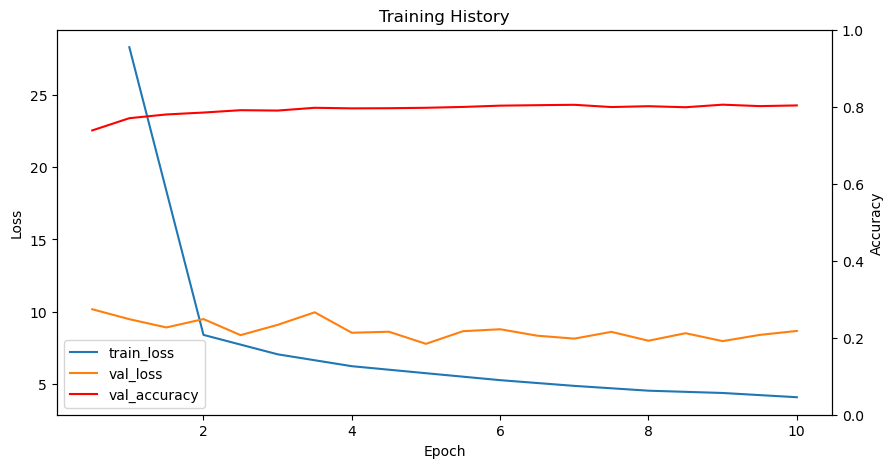

In [21]:
# Get loss, val_loss, and the computed metric from history
loss = [x['loss'] for x in history if 'loss' in x]
val_loss = [x['eval_loss'] for x in history if 'eval_loss' in x]

# Get accuracy value 
metric = [x['eval_spearmanr'] for x in history if 'eval_spearmanr' in x]

epochs_loss = [x['epoch'] for x in history if 'loss' in x]
epochs_eval = [x['epoch'] for x in history if 'eval_loss' in x]

# Create a figure with two y-axes
fig, ax1 = plt.subplots(figsize=(10, 5))
ax2 = ax1.twinx()

# Plot loss and val_loss on the first y-axis
# For the loss we plot a horizontal line because we have just one loss value (after the first epoch)
# Exchange the two lines below if you trained multiple epochs
#line1 = ax1.plot([0]+epochs_loss, loss*2, label='train_loss')
line1 = ax1.plot(epochs_loss, loss, label='train_loss')

line2 = ax1.plot(epochs_eval, val_loss, label='val_loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

# Plot the computed metric on the second y-axis
line3 = ax2.plot(epochs_eval, metric, color='red', label='val_accuracy')
ax2.set_ylabel('Accuracy')
ax2.set_ylim([0, 1])

# Combine the lines from both y-axes and create a single legend
lines = line1 + line2 + line3
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='lower left')

# Show the plot
plt.title("Training History")
plt.show()

# Save and Load the finetuned model

In [22]:
def save_model(model,filepath):
# Saves all parameters that were changed during finetuning

    # Create a dictionary to hold the non-frozen parameters
    non_frozen_params = {}

    # Iterate through all the model parameters
    for param_name, param in model.named_parameters():
        # If the parameter has requires_grad=True, add it to the dictionary
        if param.requires_grad:
            non_frozen_params[param_name] = param

    # Save only the finetuned parameters 
    torch.save(non_frozen_params, filepath)

    
def load_model(checkpoint, filepath, mixed = True, full = False, deepspeed=True):
# Creates a new PT5 model and loads the finetuned weights from a file

    # load model
    if "esm" in checkpoint:
        model, tokenizer = load_esm_model_regression(checkpoint, mixed, full, deepspeed)
    else:
        model, tokenizer = load_T5_model_regression(checkpoint, mixed, full, deepspeed)
    
    # Load the non-frozen parameters from the saved file
    non_frozen_params = torch.load(filepath)

    # Assign the non-frozen parameters to the corresponding parameters of the model
    for param_name, param in model.named_parameters():
        if param_name in non_frozen_params:
            param.data = non_frozen_params[param_name].data

    return tokenizer, model

This saves only the finetuned weights to a .pth file

The file has a size of only a few MB, while the entire model would be around 4.8 GB

In [23]:
save_model(model,"./scripts/Finetuning/PT5/ProtT5_disorder_finetuned.pth")

To load the weights again, we initialize a new PT5 model from the pretrained checkpoint and load the LoRA weights afterwards

You need to specifiy the correct num_labels here

In [24]:
tokenizer, model_reload = load_model(checkpoint, "./scripts/Finetuning/PT5/ProtT5_disorder_finetuned.pth")

loading file spiece.model from cache at /data2/cache/huggingface/hub/models--Rostlab--prot_t5_xl_half_uniref50-enc/snapshots/94a6abc029ae13029317b140b7424e012bf8dfbf/spiece.model
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /data2/cache/huggingface/hub/models--Rostlab--prot_t5_xl_half_uniref50-enc/snapshots/94a6abc029ae13029317b140b7424e012bf8dfbf/special_tokens_map.json
loading file tokenizer_config.json from cache at /data2/cache/huggingface/hub/models--Rostlab--prot_t5_xl_half_uniref50-enc/snapshots/94a6abc029ae13029317b140b7424e012bf8dfbf/tokenizer_config.json
loading configuration file config.json from cache at /data2/cache/huggingface/hub/models--Rostlab--prot_t5_xl_half_uniref50-enc/snapshots/94a6abc029ae13029317b140b7424e012bf8dfbf/config.json
Model config T5Config {
  "_name_or_path": "Rostlab/prot_t5_xl_half_uniref50-enc",
  "architectures": [
    "T5EncoderModel"
  ],
  "d_ff": 16384,
  "d_kv": 128,
  "d_model": 1024,
 

T5_Classfier
Trainable Parameter: 1208142849
T5_LoRA_Classfier
Trainable Parameter: 1968129



To check if the original and the reloaded models are identical we can compare weights

In [25]:
# Put both models to the same device
model=model.to("cpu")
model_reload=model_reload.to("cpu")

# Iterate through the parameters of the two models and compare the data
for param1, param2 in zip(model.parameters(), model_reload.parameters()):
    if not torch.equal(param1.data, param2.data):
        print("Models have different weights")
        break
else:
    print("Models have identical weights")

Models have identical weights


# Make predictions on a test set

We first load the SETH test dataset

In [26]:
# Load test sequences
url = "https://raw.githubusercontent.com/DagmarIlz/SETH/main/datasets/CheZOD117_test_set_sequences.fasta"

response = requests.get(url)
response.raise_for_status()  # Check if the request was successful

# Create a StringIO object to simulate a file-like object
fasta_file = StringIO(response.text)

# Load FASTA file using Biopython
sequences = []
for record in SeqIO.parse(fasta_file, "fasta"):
    sequences.append([record.name, str(record.seq)])

# Create dataframe
df = pd.DataFrame(sequences, columns=["name", "sequence"])
df.head(5)

,name,sequence
0,18927,NREIQPPFKPKVSGKGAENFDKFFTRGQPVLTPPDQLVIANIDQSD...
1,19650,LLDKDDSKAGMEEDHTYEGLDIDQTATYEDIVTLRTGEVKWSVGEHPGQ
2,15141,AKRSHQAIIMSTSLRVSPSIHGYHFDTASRKKAVGNIFENTDQESL...
3,15768,STNPKPQRKTKRNTNRRPQDVKFPGGGQIVGGVYLLPRRGPRSQPR...
4,17483,DAGRKGFGEKASEALKPDSQKSYAEQGKEYITDKADKVAGKVQPED...


In [27]:
# Load test labels (CheZOD_scores) 
# here each test sequence label comes from it's own file

labels=[] 

for n in list(df.name):
    url = "https://raw.githubusercontent.com/DagmarIlz/SETH/main/datasets/CheZOD117_test_set_CheZOD_scores/zscores"+n+".txt"

    response = requests.get(url)
    response.raise_for_status()  # Check if the request was successful
    
    lines = response.text.splitlines()
    
    label=[]
    
    for l in lines:
        label.append(l.split(" ")[-1]) 
    
    labels.append(label)

for l in range(0,len(labels)):
    labels[l]=[float(label) for label in labels[l]]
    
df["label"] = labels
df.head(5)

,name,sequence,label
0,18927,NREIQPPFKPKVSGKGAENFDKFFTRGQPVLTPPDQLVIANIDQSD...,"[0.908, -0.087, 0.389, -1.393, -0.438, -2.381,..."
1,19650,LLDKDDSKAGMEEDHTYEGLDIDQTATYEDIVTLRTGEVKWSVGEHPGQ,"[0.986, 1.055, -1.049, -0.312, 1.064, 2.683, 2..."
2,15141,AKRSHQAIIMSTSLRVSPSIHGYHFDTASRKKAVGNIFENTDQESL...,"[-0.251, 0.539, 0.032, 0.33, -2.182, -1.09, 0...."
3,15768,STNPKPQRKTKRNTNRRPQDVKFPGGGQIVGGVYLLPRRGPRSQPR...,"[7.239, 8.155, 6.443, 6.22, 4.927, 4.947, 2.98..."
4,17483,DAGRKGFGEKASEALKPDSQKSYAEQGKEYITDKADKVAGKVQPED...,"[-2.544, -2.447, -1.615, -1.252, -0.973, -2.00..."


In [28]:
test = df[["sequence", "label"]]

# replace invalid values above 900 with -100
test['label'] = test.apply(lambda row:  [-100 if x > 900 else x for x in row['label']], axis=1)

# preprocess data
test["sequence"] = test["sequence"].str.replace('|'.join(["O","B","U","Z","J"]),"X",regex=True)
test['sequence'] = test.apply(lambda row : " ".join(row["sequence"]), axis = 1)

test.head(5)

/tmp/ipykernel_261625/2346974570.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['label'] = test.apply(lambda row:  [-100 if x > 900 else x for x in row['label']], axis=1)
/tmp/ipykernel_261625/2346974570.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["sequence"] = test["sequence"].str.replace('|'.join(["O","B","U","Z"]),"X",regex=True)
/tmp/ipykernel_261625/2346974570.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

,sequence,label
0,N R E I Q P P F K P K V S G K G A E N F D K F ...,"[0.908, -0.087, 0.389, -1.393, -0.438, -2.381,..."
1,L L D K D D S K A G M E E D H T Y E G L D I D ...,"[0.986, 1.055, -1.049, -0.312, 1.064, 2.683, 2..."
2,A K R S H Q A I I M S T S L R V S P S I H G Y ...,"[-0.251, 0.539, 0.032, 0.33, -2.182, -1.09, 0...."
3,S T N P K P Q R K T K R N T N R R P Q D V K F ...,"[7.239, 8.155, 6.443, 6.22, 4.927, 4.947, 2.98..."
4,D A G R K G F G E K A S E A L K P D S Q K S Y ...,"[-2.544, -2.447, -1.615, -1.252, -0.973, -2.00..."


Then we create predictions on our test data using the model we trained before

In [29]:
# Set the device to use
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Create Dataset
test_set=create_dataset(tokenizer,list(test['sequence']),list(test['label']),checkpoint)
# Make compatible with torch DataLoader
test_set = test_set.with_format("torch", device=device)

# For token regression we need a data collator here to pad correctly
if ("esm" in checkpoint) or ("ProstT5" in checkpoint):
    data_collator = DataCollatorForTokenRegression_esm(tokenizer) 
# For Ankh and ProtT5 pad only at the end
else:
    data_collator = DataCollatorForTokenRegression_t5(tokenizer)    

# Create a dataloader for the test dataset
test_dataloader = DataLoader(test_set, batch_size=16, shuffle = False, collate_fn = data_collator)

# Put the model in evaluation mode
model.eval()

# Make predictions on the test dataset
predictions = []
# We need to collect the batch["labels"] as well, this allows us to filter out all positions with a -100 afterwards
padded_labels = []

with torch.no_grad():
    for batch in tqdm(test_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        # Padded labels from the data collator
        padded_labels += batch['labels'].tolist()
        # Add batch results(logits) to predictions, we take the argmax here to get the predicted class
        predictions += model.float()(input_ids, attention_mask=attention_mask).logits.squeeze().tolist()

100%|██████████| 8/8 [00:11<00:00,  1.44s/it]


Finally, we compute our desired performance metric for the test data

In [30]:
# to make it easier we flatten both the label and prediction lists
def flatten(l):
    return [item for sublist in l for item in sublist]

# flatten and convert to np array for easy slicing in the next step
predictions = np.array(flatten(predictions))
padded_labels = np.array(flatten(padded_labels))

# Filter out all invalid (label = -100) values
predictions = predictions[padded_labels!=-100]
padded_labels = padded_labels[padded_labels!=-100]

# Calculate classification Accuracy
print("Spearman: ", stats.spearmanr(a=predictions, b=padded_labels, axis=0).correlation)

Spearman:  0.7221329212807391


Great, 72.2% Spearman is a decent test performance for this test dataset (see [SETH](https://www.frontiersin.org/articles/10.3389/fbinf.2022.1019597/full) results )

Further hyperparameter optimization and using a CNN prediction head will further increase performance